In [24]:
import os
import datetime
import ffmpeg
import lxml.etree as ET
import matplotlib.pyplot as plt
from typing import Tuple
from bisect import bisect_left, bisect_right


# Remux


In [4]:
dir = os.path.abspath("/mnt/d/Videos/ApixC/apixC_MC终末旅行/transcode")
# dir = os.path.abspath("../recordings/")
# dir = "/mnt/c/Users/yiguo/Desktop/BiliRec_tmp/tmp/"
# dir = "/mnt/e/BiliRec_apixC/transcode/"

command_list = []
for file in os.listdir(dir):
    if file.endswith(".flv"):
        if " " in file:
            file = "\ ".join(file.split(" "))
        command = "ffmpeg -i " + file + " -c:a copy -c:v copy " + file[:-3] + "mp4"
        command_list.append(command)


command_merged = "; ".join(command_list)
print(command_merged)


# Sync Video and Danmaku (scale danmaku time)

In [92]:
dir = "/mnt/d/Videos/ApixC/apixC_MC终末旅行/footages/day4/"
# dir = "/mnt/d/Videos/ApixC/apixC_MC终末旅行/transcode/"
specific_file = "92613_20230401_032353_mc.flv"
# specific_file = ""

for flv_file in os.listdir(dir):
    if specific_file:
        if flv_file != specific_file:
            continue
    if flv_file.endswith(".flv"):
        xml_file = flv_file[:-3] + "xml"
        if os.path.exists(os.path.join(dir, xml_file)):
            flv_modified_time = os.path.getmtime(os.path.join(dir, flv_file))
            media_info = ffmpeg.probe(os.path.join(dir, flv_file))
            flv_creation_time = datetime.datetime.strptime(media_info["format"]['tags']["StartTime"], "%a, %d %b %Y %H:%M:%S %z").timestamp()
            flv_file_duration = flv_modified_time - flv_creation_time
            flv_media_duration = float(media_info["format"]["duration"])
            xml_modified_time = os.path.getmtime(os.path.join(dir, xml_file))
            tree = ET.parse(os.path.join(dir, xml_file))
            root = tree.getroot()
            xml_creation_time = datetime.datetime.strptime(root.find("BililiveRecorderRecordInfo").attrib["start_time"][:26], "%Y-%m-%dT%H:%M:%S.%f").timestamp()
            xml_file_duration = xml_modified_time - xml_creation_time
            print(flv_file_duration - xml_file_duration, flv_media_duration - xml_file_duration, (flv_media_duration - xml_file_duration) / xml_file_duration * 1e4, flv_file)
            # scale the time of the xml file if difference is too large
            if abs(flv_media_duration - xml_file_duration) > 5:
                for child in root.findall("d"):
                    if child.tag == "d":
                        _ = child.attrib["p"].split(",")
                        danmaku_sec = float(_[0])
                        danmaku_sec *= flv_media_duration / xml_file_duration
                        _[0] = f"{danmaku_sec:.3f}"
                        _[4] = str(round((xml_creation_time + (float(_[4]) * 1e-3 - xml_creation_time) * flv_media_duration / xml_file_duration) * 1e3))
                        child.attrib["p"] = ",".join(_)
                    elif child.tag == "sc":
                        danmaku_sec = float(child.attrib["ts"])
                        danmaku_sec *= flv_media_duration / xml_file_duration
                        child.attrib["ts"] = f"{danmaku_sec:.3f}"
            # write the xml file
            tree.write(os.path.join(dir, xml_file[:-4] + "_scaled.xml"), encoding="utf-8", xml_declaration=True)


-12.91087794303894 -178.34473217201594 -51.53542940792321 92613_20230401_032353_mc.flv


# Split Recording


In [102]:
# dir = os.path.abspath("../recordings") + "/"
dir = os.path.abspath("/mnt/d/Videos/ApixC/apixC_MC终末旅行/") + "/"
filename = "92613_20230401_032353_mc"
split_time = "02:50:25"


assert len(split_time) == 8
assert len(split_time.split(":")) == 3
tmp = split_time.split(":")
split_sec = 3600 * float(tmp[0]) + 60 * float(tmp[1]) + float(tmp[2])

recording_path = dir + filename + ".mp4"
xml_path = dir + filename + ".xml"
assert os.path.isfile(recording_path)
assert os.path.isfile(xml_path)


filename_part1 = filename + "_part1"
filename_part2 = filename + "_part2"
tmp = filename_part2.split("_", 3)
start_time = datetime.datetime.strptime("".join(tmp[1:3]), "%Y%m%d%H%M%S")
start_time_part2 = start_time + datetime.timedelta(seconds=split_sec)
filename_part2 = (
    tmp[0] + datetime.datetime.strftime(start_time_part2, "_%Y%m%d_%H%M%S_") + tmp[3]
)
recording_part1_path = dir + filename_part1 + ".mp4"
recording_part2_path = dir + filename_part2 + ".mp4"
xml_part1_path = dir + filename_part1 + ".xml"
xml_part2_path = dir + filename_part2 + ".xml"


print("Preparing to split")
print(recording_path)
print(xml_path)
print("at " + split_time)
print("Expecting to generate")
print(recording_part1_path)
print(xml_part1_path)
print(recording_part2_path)
print(xml_part2_path)


Preparing to split
/mnt/d/Videos/ApixC/apixC_MC终末旅行/92613_20230401_032353_mc.mp4
/mnt/d/Videos/ApixC/apixC_MC终末旅行/92613_20230401_032353_mc.xml
at 02:50:25
Expecting to generate
/mnt/d/Videos/ApixC/apixC_MC终末旅行/92613_20230401_032353_mc_part1.mp4
/mnt/d/Videos/ApixC/apixC_MC终末旅行/92613_20230401_032353_mc_part1.xml
/mnt/d/Videos/ApixC/apixC_MC终末旅行/92613_20230401_061418_mc_part2.mp4
/mnt/d/Videos/ApixC/apixC_MC终末旅行/92613_20230401_061418_mc_part2.xml


### Split Video


In [24]:
command_list = []
command_list.append(
    "ffmpeg -i "
    + filename
    + ".mp4 -to "
    + split_time
    + " -c:a copy -c:v copy "
    + filename_part1
    + ".mp4"
)
command_list.append(
    "ffmpeg -i "
    + filename
    + ".mp4 -ss "
    + split_time
    + " -c:a copy -c:v copy "
    + filename_part2
    + ".mp4"
)
if " " in filename:
    print("Please remove spaces in the filename")
else:
    print("; ".join(command_list))


ffmpeg -i 47867_20230331_031928_最后一天P5X一测.mp4 -to 01:28:00 -c:a copy -c:v copy 47867_20230331_031928_最后一天P5X一测_part1.mp4; ffmpeg -i 47867_20230331_031928_最后一天P5X一测.mp4 -ss 01:28:00 -c:a copy -c:v copy 47867_20230331_044728_最后一天P5X一测_part2.mp4


### Split Danmaku


In [103]:
def split_danmaku(xml_file: str, split_sec: float) -> Tuple[str, str]:
    part1, part2 = [], []

    for line in xml_file.split("\n"):
        if line.startswith("  <d") or line.startswith("  <sc"):
            # continue
            [seg1, tmp] = line.split('"', 1)
            seg1 += '"'
            [seg2, seg3] = tmp.split(".", 1)
            seg2 += "." + seg3[:3]
            seg3 = seg3[3:]

            danmaku_time = float(seg2)
            if danmaku_time < split_sec:
                part1.append(seg1 + f"{danmaku_time:.3f}" + seg3)
            else:
                danmaku_time -= split_sec
                part2.append(seg1 + f"{danmaku_time:.3f}" + seg3)
        elif line.startswith("  <BililiveRecorderRecordInfo"):
            # continue
            [seg1, tmp] = line.split('start_time="', 1)
            seg1 += 'start_time="'
            [seg2, seg3] = tmp.split('"', 1)
            seg3 = '"' + seg3
            start_time = datetime.datetime.strptime(seg2[:26], "%Y-%m-%dT%H:%M:%S.%f")
            start_time += datetime.timedelta(seconds=split_sec)
            seg2 = (
                datetime.datetime.strftime(start_time, "%Y-%m-%dT%H:%M:%S.%f")
                + seg2[26:]
            )
            new_line = seg1 + seg2 + seg3
            part1.append(line)
            part2.append(new_line)
        else:
            part1.append(line)
            part2.append(line)

    return "\n".join(part1), "\n".join(part2)


In [26]:
def split_danmaku2(xml_file: str, split_sec: float) -> Tuple[str, str]:
    root = ET.fromstring(xml_file)
    for child in root:
        print(child.attrib)

    return "", ""



In [104]:
with open(dir + filename + ".xml", "r") as f:
    xml_file = f.read()


part1, part2 = split_danmaku(xml_file, split_sec)
# part1, part2 = split_danmaku2(xml_file, split_sec)


with open(dir + filename_part1 + ".xml", "w") as f:
    f.write(part1)
    print("written file to " + dir + filename_part1 + ".xml")


with open(dir + filename_part2 + ".xml", "w") as f:
    f.write(part2)
    print("written file to " + dir + filename_part2 + ".xml")


ValueError: could not convert string to float: '60" p="75.729'

# Filter, Relocate Danmaku and Transform SC


In [101]:
# dir = "/mnt/d/Videos/ApixC/apixC_MC终末旅行/footages/day4"
dir = "/mnt/d/Videos/ApixC/apixC_MC终末旅行/"
# specific_file = "92613_20230401_032353_mc_scaled.xml"
specific_file = ""

black_list = {
    "92613": [
        "1",
        "来了来了",
        "原地去世",
        "永远爱你",
        "抱歉",
        "赞",
        "妙啊",
        "有点东西",
        "很有精神",
    ],
    "12962": [
        "来了来了",
        "谢谢老板",
        "奶宝晚安",
        "牛哇牛哇",
        "赞",
        "妙啊",
        "有点东西",
        "很有精神",
    ],
    "21263282": [
        "诶嘿！",
        "睡大觉",
        "早上好",
        "加由",
        "呆",
        "AWSL",
        "疑问",
        "老板大气！点点红包抽礼物",
        "赞",
        "妙啊",
        "有点东西",
        "很有精神",
    ],
    "25206807": [
        "赞",
        "妙啊",
        "有点东西",
        "很有精神",
    ],
    "47867": [
        "嘎噢！！！",
        "1",
        "biu",
        "点击人气榜，里面有免费的人气票可以送送哦",
        "第一时间直播最新最热单机游戏，欢迎关注",
        "游戏名：女神异闻录夜幕魅影",
        "直播通知群（禁言）：568372539",
        "每日点赞可以获得亲密度哦！",
        "每天发5条弹幕可以在移动端领一个电池哦！",
        "直播通知群（禁言）：687328094",
        "加入粉丝团只需要一个粉丝团灯牌哦！",
        "赞",
        "妙啊",
        "有点东西",
        "很有精神",
    ],
    "4910271": [
        "干杯",
        "三连",
        "痴呆",
        "惊",
        "好骂",
        "赞",
        "妙啊",
        "有点东西",
        "很有精神",
    ],
    "22259479": [
        "赞",
        "妙啊",
        "有点东西",
        "很有精神",
    ],
}


for file in os.listdir(dir):
    if file.endswith(".xml") and not file.endswith("_filtered.xml"):
        # only work with specific file if specified
        if specific_file:
            if file != specific_file:
                continue
        # prefer scaled xml
        else:
            if os.path.exists(os.path.join(dir, file[:-4] + "_scaled.xml")):
                continue
        # get room id
        room_id = file.split("_")[0]
        # parse xml
        tree = ET.parse(os.path.join(dir, file))
        root = tree.getroot()
        info = root.find("BililiveRecorderRecordInfo")
        start_time = datetime.datetime.strptime(
            info.attrib["start_time"][:26], "%Y-%m-%dT%H:%M:%S.%f"
        )
        # filter danmaku
        for child in root.findall("d"):
            if child.text in black_list[room_id]:
                root.remove(child)
        # find average danmaku delay
        danmaku_delay = []
        for child in root.findall("d"):
            p = child.attrib["p"].split(",")
            sec = float(p[0])
            new_sec = float(p[4]) / 1000 - start_time.timestamp()
            danmaku_delay.append(sec - new_sec)
        average_delay = sum(danmaku_delay) / len(danmaku_delay)
        # treat danmaku
        for child in root.findall("d"):
            p = child.attrib["p"].split(",")
            new_sec = float(p[4]) / 1000 - start_time.timestamp() + average_delay
            p[0] = f"{new_sec:.3f}"
            p[1] = "1"
            child.attrib["p"] = ",".join(p)
        # treat sc
        for child in root.findall("sc"):
            sec = child.attrib["ts"]
            user = child.attrib["user"]
            uid = child.attrib["uid"]
            price = child.attrib["price"]
            del child.attrib["ts"]
            del child.attrib["user"]
            del child.attrib["uid"]
            del child.attrib["price"]
            child.tag = "d"
            timestamp = str(round((start_time.timestamp() + float(sec)) * 1000))
            child.set("p", ",".join([sec, "3", "25", "16772431", timestamp, "0", uid, "0"]))
            child.set("user", user)
            if child.text == None:
                child.text = f"【无言SC¥{price}】" + user
            else:
                child.text = f"【SC¥{price}】" + user + ":" + child.text

        # sort elements with tag "d" by time, leave other elements untouched
        root[:] = sorted(root, key=lambda child: child.tag == "d" and float(child.attrib["p"].split(",")[0]))

        tree.write(
            os.path.join(dir, file[:-4] + "_filtered.xml"),
            encoding="utf-8",
            xml_declaration=True,
        )



# Extract Danmaku


In [2]:
def extract_danmaku(dir: str, start_time: str, duration: str):
    """Ex:

    dir = "/mnt/c/Users/yiguo/Desktop/apixC_末日合集/progress_bar/"

    start_time = "20220728_040246"

    duration = "04:06:41"
    """

    # load time
    start_datetime = datetime.datetime.strptime(start_time, "%Y%m%d_%H%M%S")
    duration_sec = 0
    for num_str in duration.split(":"):
        duration_sec *= 60
        duration_sec += int(num_str)
    end_datetime = start_datetime + datetime.timedelta(seconds=duration_sec)
    start_ts = start_datetime.timestamp()
    end_ts = end_datetime.timestamp()

    # load all xml files
    xml_list = []
    for file in os.listdir(dir):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(dir, file))
            root = tree.getroot()
            xml_list.append({"file": file, "root": root})

    # load all danmaku we want to extract
    danmaku_list = []
    for obj in xml_list:
        count = 0
        for child in obj["root"]:
            if child.tag == "d":
                p = child.attrib["p"].split(",")
                timestamp = float(p[4]) / 1000
                if start_ts <= timestamp and timestamp < end_ts:
                    count += 1
                    sec = round(timestamp - start_ts)
                    timecode = (
                        f"{sec // 3600:02d}:{(sec // 60) % 60:02d}:{sec % 60:02d}"
                    )
                    danmaku_list.append(
                        {
                            "timestamp": timestamp,
                            "sec": sec,
                            "timecode": timecode,
                            "text": child.text,
                            "user": child.attrib["user"],
                            "uid": p[-2],
                        }
                    )

    # sort in ascending order
    danmaku_list.sort(key=lambda e: e["timestamp"])

    return danmaku_list


# Generate Overall Danmaku Hotspot Diagram


In [4]:
dir = "/mnt/d/videos/ApixC/apixC_MC终末旅行/tmp/"
start_time = "20230401_032353"
duration = "09:33:47"
black_list = [
    "1",
    "嗷呜",
    "打卡",
    "第一时间直播最新最热单机游戏，欢迎关注",
    "赞",
    "妙啊",
    "有点东西",
    "很有精神",
    "爱你",
    "打电动",
    "吃零食",
    "晚安喵",
    "棒",
    "来了来了",
    "原地去世",
    "永远爱你",
    "抱歉",
]


danmaku_list = extract_danmaku(dir, start_time, duration)
sec_list = [d["sec"] for d in danmaku_list if d["text"] not in black_list]
sec_list.sort()  # sort again just to make sure


Segment duration = 34427.000 sec


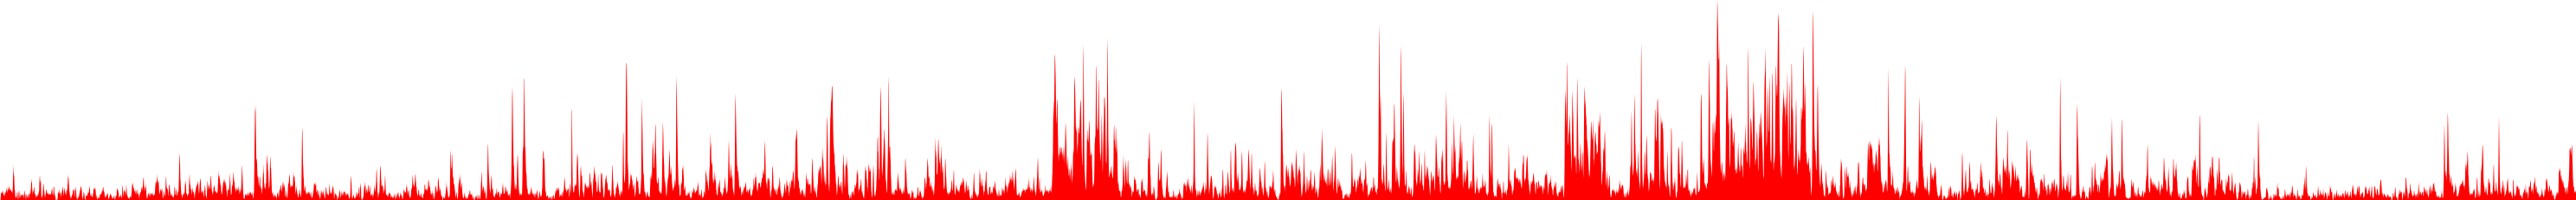

In [12]:
npoint = 10000
average_radius = 5  # seconds
# resolution = [3840, 82]  # pixels
resolution = [3840, 300]  # pixels
nsegment = 1
# color = "#f8a8b5"
# alpha = 1.0
# color = "#ffeea9"
color = "#f00"
alpha = 1.0
save_dir = "/mnt/d/Videos/ApixC/apixC_MC终末旅行/tmp/"


duration_sec = 0
for num_str in duration.split(":"):
    duration_sec *= 60
    duration_sec += int(num_str)
print(f"Segment duration = {duration_sec / nsegment:.3f} sec")

for iseg in range(nsegment):
    xmin = duration_sec / nsegment * iseg
    xmax = duration_sec / nsegment * (iseg + 1)
    xstep = (xmax - xmin) / (npoint - 1)
    x_list = [xmin + xstep * _ for _ in range(npoint)]

    xmin_index = bisect_left(sec_list, xmin)
    xmax_index = bisect_right(sec_list, xmax)
    working_list = [-float("inf")] + sec_list[xmin_index:xmax_index] + [float("inf")]
    hi, lo = 0, 0
    y_list = []
    for x in x_list:
        left = x - average_radius
        right = x + average_radius
        while working_list[lo] < left:
            lo += 1
        while working_list[hi] < right:
            hi += 1
        y_list.append(hi - lo)

    dpi = 1
    figsize = tuple(_ / dpi for _ in resolution)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.fill_between(x_list, y_list, [0] * len(x_list), color=color, alpha=alpha)
    plt.xlim([xmin, xmax])
    plt.ylim([0, max(y_list)])
    plt.axis("off")
    plt.savefig(
        save_dir
        + "hotspot_"
        + start_time
        + "_"
        + color
        + "_part"
        + str(iseg + 1)
        + ".png",
        bbox_inches="tight",
    )
    plt.show()


# Extract Clip


In [26]:
# dir_list = ["../recordings"]
dir_list = [
    "/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/",
    "/mnt/c/Users/yiguo/Desktop/BiliRec_tmp/tmp/",
    "/mnt/c/Users/yiguo/Desktop/BiliRec_tmp/saved/",
    "/mnt/e/BiliRec_apixC/saved/",
    "/mnt/e/BiliRec_apixC/trash/",
]


file_list = []
for dir in dir_list:
    for file in os.listdir(dir):
        if (file.endswith(".mp4") or file.endswith(".flv")) and (
            file.startswith("92613") or file.startswith("47867")
        ):
            [roomid, date, time, _] = file.split("_")
            start_ts = datetime.datetime.strptime(
                date + time, "%Y%m%d%H%M%S"
            ).timestamp()

            info = ffmpeg.probe(os.path.join(dir, file))
            end_ts = start_ts + float(info["format"]["duration"])

            file_list.append([dir, file, start_ts, end_ts])


In [80]:
# clip_time = "20220720_084448"  # Real world local time (Pacific)
# title = "capi去炸楼还是去地铁pi地铁c那我跟你一起"
# clip_time = "20220720_084400"  # Real world local time (Pacific)
# title = "c他原来夸夸我是为了找我要钻石，互丢钻石"
clip_time = "20220720_094205"  # Real world local time (Pacific)
title = "c啊对对对"
duration = 60  # seconds
out_dir = "/mnt/c/Users/yiguo/Videos/extracted_clips/"


clip_ts = datetime.datetime.strptime(clip_time, "%Y%m%d_%H%M%S").timestamp()

for [dir, file, start_ts, end_ts] in file_list:
    if start_ts < clip_ts and clip_ts < end_ts:
        print("Found clip in " + file)
        assert start_ts < clip_ts - duration / 2
        assert end_ts > clip_ts + duration / 2

        start = round(clip_ts - duration / 2 - start_ts)

        if file.startswith("92613"):
            appendix = "_api"
        else:
            appendix = "_c"
        recording_path = os.path.join(dir, file)
        output_path = os.path.join(out_dir, clip_time + "_" + title + appendix + ".mp4")

        print(
            f"ffmpeg -i {recording_path} -ss {start} -t {duration} -c:a copy -c:v copy {output_path}\n"
        )



Found clip in 47867_20220720_054649_MC末世生存day2.mp4
ffmpeg -i /mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220720_054649_MC末世生存day2.mp4 -ss 14086 -t 60 -c:a copy -c:v copy /mnt/c/Users/yiguo/Videos/extracted_clips/20220720_094205_c啊对对对_c.mp4

Found clip in 92613_20220720_043416_末世2DLC.mp4
ffmpeg -i /mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/92613_20220720_043416_末世2DLC.mp4 -ss 18439 -t 60 -c:a copy -c:v copy /mnt/c/Users/yiguo/Videos/extracted_clips/20220720_094205_c啊对对对_api.mp4

